In [82]:
import os
import librosa
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [83]:
DATA_PATH = r"C:\Users\admin\OneDrive\Time_series\data"
SAMPLE_RATE = 16000
N_MFCC = 13
GMM_COMPONENTS = 8
BATCH_SIZE = 16
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [84]:
def load_audio_files(base_path):
    X = []
    y = []
    labels = os.listdir(base_path)
    for label in labels:
        folder = os.path.join(base_path, label)
        if not os.path.isdir(folder):
            continue
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                file_path = os.path.join(folder, file)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)  # shape=(n_mfcc, time)
                mfcc = mfcc.T  # chuyển về (time, n_mfcc)
                X.append(mfcc)
                y.append(label)
    return X, y

X, y = load_audio_files(DATA_PATH)
print(f"Loaded {len(X)} audio samples")


Loaded 7132 audio samples


In [85]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [86]:
all_frames = np.vstack(X)  # ghép tất cả các frame MFCC lại thành 1 mảng (tổng frames, n_mfcc)
gmm = GaussianMixture(n_components=GMM_COMPONENTS, covariance_type='diag', random_state=42)
gmm.fit(all_frames)
print("GMM trained on all MFCC frames")

GMM trained on all MFCC frames


In [87]:
def encode_with_gmm(mfcc_seq, gmm_model):
    probs = gmm_model.predict_proba(mfcc_seq)  # shape = (time, GMM_COMPONENTS)
    return probs

X_encoded = [encode_with_gmm(x, gmm) for x in X]

In [88]:
class AudioDataset(Dataset):
    def __init__(self, X_enc, y_enc):
        self.X = X_enc
        self.y = y_enc
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), self.y[idx]

dataset = AudioDataset(X_encoded, y_encoded)

In [89]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded_seqs = pad_sequence(sequences, batch_first=True)  # (batch, max_len, features)
    labels = torch.LongTensor(labels)
    return padded_seqs.to(DEVICE), labels.to(DEVICE), lengths

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [90]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, nhead, nhid, nlayers, nclasses, dropout=0.1):
        super().__init__()
        self.pos_encoder = PositionalEncoding(input_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=nlayers)
        self.fc = nn.Linear(input_dim, nclasses)

    def forward(self, src, src_mask=None):
        # src shape: (batch, seq_len, input_dim)
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch, feature)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)  # (seq_len, batch, feature)
        output = output.mean(dim=0)  # mean pooling over time dimension
        output = self.fc(output)  # (batch, nclasses)
        return output

In [91]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0),]
        return self.dropout(x)

In [92]:
input_dim = GMM_COMPONENTS
nhead = 2
nhid = 128
nlayers = 2
nclasses = len(le.classes_)
model = TransformerClassifier(input_dim, nhead, nhid, nlayers, nclasses).to(DEVICE)


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [93]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_x, batch_y, lengths in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

print("Hoàn thành.")

Epoch 1/10, Loss: 0.8511
Epoch 2/10, Loss: 0.5179
Epoch 3/10, Loss: 0.4579
Epoch 4/10, Loss: 0.4388
Epoch 5/10, Loss: 0.4221
Epoch 6/10, Loss: 0.4053
Epoch 7/10, Loss: 0.3992
Epoch 8/10, Loss: 0.3829
Epoch 9/10, Loss: 0.3620
Epoch 10/10, Loss: 0.3569
Hoàn thành.


In [94]:
# Đưa model về chế độ đánh giá
model.eval()

# Duyệt toàn bộ tập dữ liệu để in nhãn dự báo và nhãn thực tế
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y, lengths in dataloader:
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1)  # Chọn lớp có xác suất cao nhất
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Giải mã về nhãn gốc
pred_labels = le.inverse_transform(all_preds)
true_labels = le.inverse_transform(all_targets)

# In ra kết quả từng mẫu
print("\nDự đoán vs Thực tế:")
for pred, true in zip(pred_labels, true_labels):
    print(f"Predicted: {pred:10s} | True: {true:10s}")



Dự đoán vs Thực tế:
Predicted: no         | True: no        
Predicted: stop       | True: stop      
Predicted: no         | True: no        
Predicted: no         | True: no        
Predicted: yes        | True: yes       
Predicted: stop       | True: stop      
Predicted: yes        | True: yes       
Predicted: yes        | True: yes       
Predicted: yes        | True: yes       
Predicted: no         | True: no        
Predicted: yes        | True: yes       
Predicted: stop       | True: no        
Predicted: stop       | True: stop      
Predicted: no         | True: no        
Predicted: yes        | True: yes       
Predicted: no         | True: no        
Predicted: stop       | True: stop      
Predicted: yes        | True: yes       
Predicted: stop       | True: stop      
Predicted: yes        | True: yes       
Predicted: yes        | True: yes       
Predicted: stop       | True: stop      
Predicted: yes        | True: yes       
Predicted: stop       | True: stop  

In [95]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(all_targets, all_preds)
print(f"\nAccuracy: {acc*100:.2f}%")



Accuracy: 89.05%


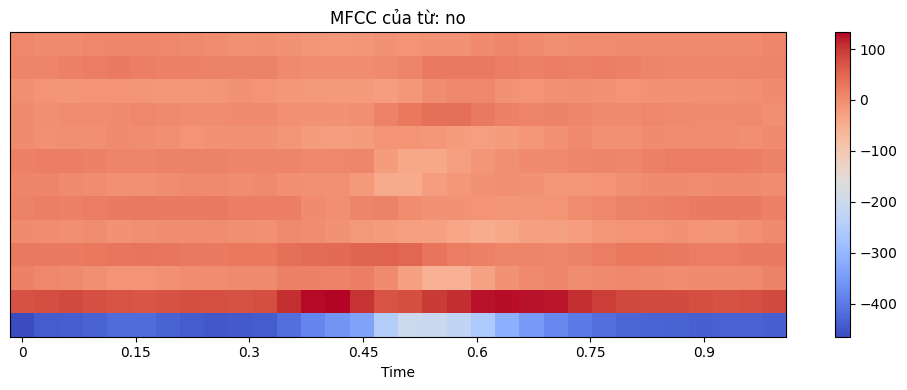

In [98]:
import librosa.display
import matplotlib.pyplot as plt

# Lấy MFCC của một mẫu bất kỳ
sample_idx = 0
mfcc = X[sample_idx].T  # (n_mfcc, time)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()
plt.title(f"MFCC của từ: {y[sample_idx]}")
plt.tight_layout()
plt.show()
